# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

In [1]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

## Откройте и изучите файл

In [2]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/users_behavior.csv')
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


Файл прочитан корректно. Выведем общую информацию по датасету

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


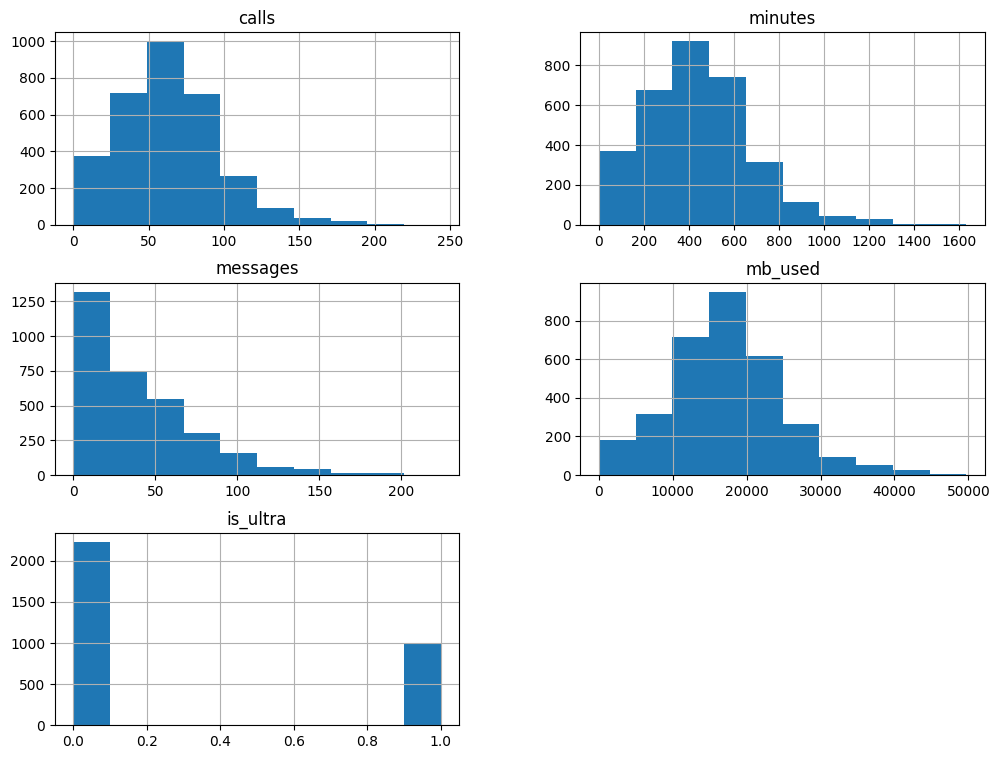

In [4]:
df.hist(figsize = (12, 9));

In [5]:
df.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


In [6]:
df.corr()

,calls,minutes,messages,mb_used,is_ultra
calls,1.000000,0.982083,0.177385,0.286442,0.207122
minutes,0.982083,1.000000,0.173110,0.280967,0.206955
messages,0.177385,0.173110,1.000000,0.195721,0.203830
mb_used,0.286442,0.280967,0.195721,1.000000,0.198568
is_ultra,0.207122,0.206955,0.203830,0.198568,1.000000


## Разбейте данные на выборки

Целевой признак в нашем исследовании - `is_ultra`. Выделим его и разобъём наши данные на обучающую, валидационную и тестовую выборки в соотношении 3:1:1

In [7]:
features = df.drop('is_ultra', axis = 1)
target = df['is_ultra']
initial_features, test_features, initial_target, test_target = \
train_test_split(features, target, test_size = 0.2, random_state = 42, stratify = target)

train_features, valid_features, train_target, valid_target = \
train_test_split(initial_features, initial_target, test_size = 0.25, random_state = 42, stratify = initial_target)

df.shape[0] == (test_features.shape[0] + train_features.shape[0] + valid_features.shape[0])

True

## Исследуйте модели

Исследуем три модели - решаюшее дерево, случайный лес и логистическую регрессию.

In [8]:
def get_best_score(model, best_model, best_score):
    model.fit(train_features, train_target)
    valid_score = model.score(valid_features, valid_target)
    test_score = model.score(test_features, test_target)
    if valid_score > best_score:
        return(model, valid_score, test_score)
    else:
        return(best_model, valid_score, test_score)

### Решающее дерево

In [9]:
best_tree_model = None
tree_train_scores = []
tree_valid_scores = []
for i in range(1, 100):
    model = DecisionTreeClassifier(max_depth = i, random_state = 42)
    if len(tree_valid_scores) > 0:
        best_tree_model, valid_score, test_score = get_best_score(model, best_tree_model, max(tree_valid_scores))
    else:
        best_tree_model, valid_score, test_score = get_best_score(model, best_tree_model, 0)
    tree_train_scores.append(test_score)
    tree_valid_scores.append(valid_score)

best_tree_score = max(tree_valid_scores)

best_tree_model, best_tree_score

(DecisionTreeClassifier(max_depth=5, random_state=42), 0.7900466562986003)

**Наилучший результат при максимальной глубине, равной пяти.**

<Axes: >

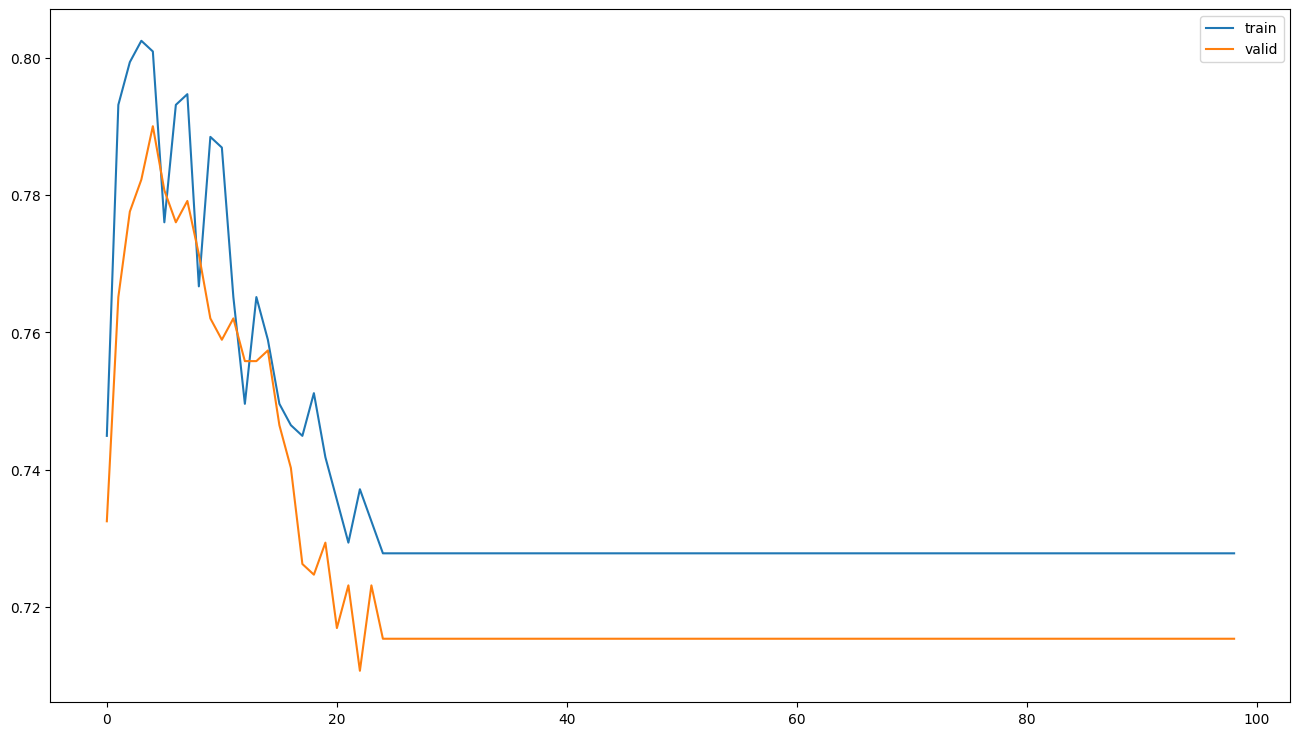

In [10]:
pd.DataFrame(zip(tree_train_scores, tree_valid_scores), columns = ['train', 'valid']).plot(figsize = (16, 9))

### Случайный лес

In [11]:
from tqdm import tqdm
best_forest_model = None
forest_train_scores = []
forest_valid_scores = []

for i in tqdm(range(1, 32, 10)):
    for j in range (1, 30):
        model = RandomForestClassifier(n_estimators = i, max_depth = j, random_state = 42)
        if len(forest_valid_scores) > 0:
            best_forest_model, valid_score, test_score = get_best_score(model, best_forest_model, max(forest_valid_scores))
        else:
            best_forest_model, valid_score, test_score = get_best_score(model, best_forest_model, 0)
        forest_train_scores.append(test_score)
        forest_valid_scores.append(valid_score)

best_forest_score = max(forest_valid_scores)
best_forest_model, best_forest_score

100%|██████████| 4/4 [00:09<00:00,  2.26s/it]


(RandomForestClassifier(max_depth=17, n_estimators=21, random_state=42),
 0.7978227060653188)

Наилучший результат при максимальной глубине, равной 17 и числе деревьев = 21.

*Примечание: диапазон поиска намеренно уменьшен постфактум. Первоначальный поиск проводился в диапазоне [1, 100] по обоим параметрам

<Axes: >

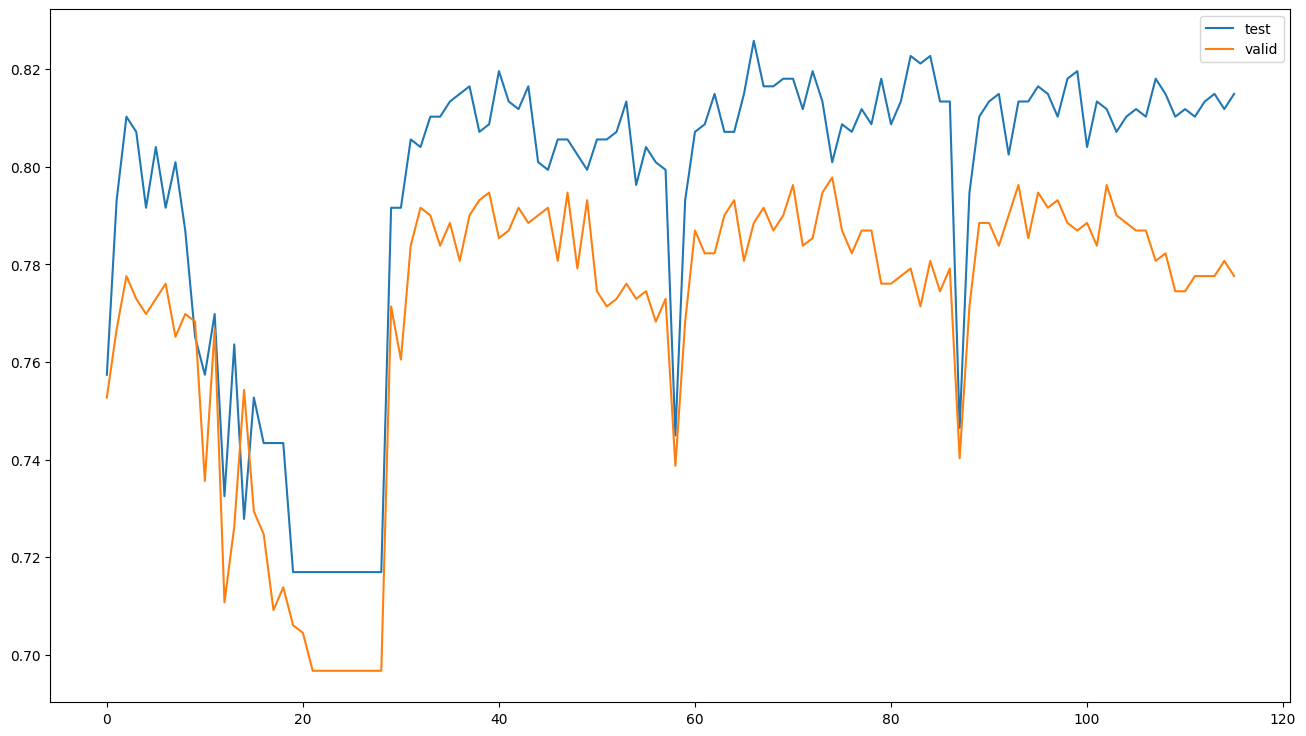

In [12]:
pd.DataFrame(zip(forest_train_scores, forest_valid_scores), columns = ['test', 'valid']).plot(figsize = (16, 9))

### Логистическая регрессия

In [13]:
best_logistic_model = None
logistic_train_scores = []
logistic_valid_scores = []
solvers = ['lbfgs', 'sag', 'saga']

for solver in solvers:
    model = LogisticRegression(random_state=42, solver=solver, max_iter=10000)
    if len(logistic_valid_scores) > 0:
        best_logistic_model, valid_score, test_score = get_best_score(model, best_logistic_model, max(logistic_valid_scores))
    else:
        best_logistic_model, valid_score, test_score = get_best_score(model, best_logistic_model, 0)
    logistic_train_scores.append(test_score)
    logistic_valid_scores.append(valid_score)

logistic_score = max(logistic_valid_scores)
best_logistic_model, logistic_score

(LogisticRegression(max_iter=10000, random_state=42), 0.744945567651633)

## Проверьте модель на тестовой выборке

Наилучшие результаты показывает модель случайного леса. Переобучим эту модель на выборке, состоящей из тренировочного и валидационного сетов

In [14]:
best_forest_model.fit(initial_features, initial_target)
best_forest_model.score(initial_features, initial_target), best_forest_model.score(test_features, test_target)

(0.9576040451186308, 0.7993779160186625)

In [15]:
best_forest_model

RandomForestClassifier(max_depth=17, n_estimators=21, random_state=42)

Итоговый результат - 79.9%



<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюераV2</b></font>

Успех:

Если студент получил на тесте accuraсy  выше 0,78, это считается отличным результатом. Тобой подбиралась лучшая комбинация не по одному гиперпараметру + дообучил и вот он результат!






</div>

**Вывод:**

Наилучшие показатели качества имеет модель случайного леса с гиреппараметрами `max_depth=17`, `n_estimators=42`. Данная модель показывает точнность 79.9% на тестовой выборке

## (бонус) Проверьте модели на адекватность

Проверим, как распределены значения в колонке `is_ultra`

In [16]:
df['is_ultra'].mean()

0.30647168637212197

В целевом признаке имеется перекос в сторону нулевого значения. Сравним нашу модель с моделью, всегда генерирующей 0

In [17]:
from sklearn.dummy import DummyClassifier

In [18]:
sanity_check = DummyClassifier()
sanity_check.fit(initial_features, initial_target)
sanity_check.score(test_features, test_target)

0.6936236391912908

Пороговое значение точности приблизительно равно 69%. Точность нашей итоговой модели - 79.9%. Проверка на адекватность пройдена.